In [14]:
print("hi this is my first time using google colab")

!pip install torch torchvision scikit-learn matplotlib
# this is useful because sometimes it might not have something. but here that's not the case nice!

hi this is my first time using google colab


In [15]:
# lets import everything
import torch #this is the overall library apparantly
import torch.nn as nn  #neural netowrk layer hmm
import torch.optim as optim  # we do need optimizers
from torch.utils.data import DataLoader, random_split

# these are related to vision
from torchvision import datasets  # fashion msnit
from torchvision import transforms

# these are all the Metrics
from sklearn.metrics import classification_report, confusion_matrix

# for graph and plot
import matplotlib.pyplot as plt
import numpy as np

In [16]:
device=torch.device("cuda")
print(device) #yay we are using gpu now

cuda


In [17]:
from google.colab import drive
drive.mount('/content/drive/') #load the datasets

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [18]:
import gzip
import struct
import numpy as np
import torch


In [19]:
import os
os.listdir('/content/drive/MyDrive/data')

['t10k-labels-idx1-ubyte.gz',
 'train-labels-idx1-ubyte.gz',
 'train-images-idx3-ubyte.gz',
 't10k-images-idx3-ubyte.gz']

In [20]:
train_images_path = "/content/drive/MyDrive/data/train-images-idx3-ubyte.gz"
train_labels_path = "/content/drive/MyDrive/data/train-labels-idx1-ubyte.gz"
test_images_path  = "/content/drive/MyDrive/data/t10k-images-idx3-ubyte.gz"
test_labels_path  = "/content/drive/MyDrive/data/t10k-labels-idx1-ubyte.gz"

In [29]:
torch.backends.cudnn.benchmark = True   # autotunes for google colab gpu

In [22]:
def read_idx_images_gz(path):
    # this function will hopefully open gz file in binary mode, return torch.FloatTensor shape (N,1,28,28) scaled [0,1]
    with gzip.open(path, 'rb') as f:
        magic, n_images, rows, cols = struct.unpack(">IIII", f.read(16))
        data = np.frombuffer(f.read(), dtype=np.uint8)
        data = data.reshape(n_images, rows, cols)
        data = data.astype(np.float32) / 255.0
        data = np.expand_dims(data, axis=1)
        return torch.from_numpy(data)   # convert to torch tensor
def read_idx_labels_gz(path):
    # open gz label file and return torch.LongTensor shape (N,)
    with gzip.open(path, 'rb') as f:
        magic, n = struct.unpack(">II", f.read(8))
        data = np.frombuffer(f.read(), dtype=np.uint8) # label bytes
        return torch.from_numpy(data.astype(np.int64)) # convert to long tensor

In [23]:
X_train_all = read_idx_images_gz(train_images_path)  # shape (60000,1,28,28)
y_train_all = read_idx_labels_gz(train_labels_path)  # shape (60000,)
X_test = read_idx_images_gz(test_images_path)        # shape (10000,1,28,28)
y_test = read_idx_labels_gz(test_labels_path)


In [28]:
# Map [0,1] -> [-1,1]: (x - 0.5) / 0.5
X_train_all = (X_train_all - 0.5) / 0.5
X_test = (X_test - 0.5) / 0.5
# normalizing helps descent

In [25]:
from torch.utils.data import TensorDataset, random_split, DataLoader

full_train_ds = TensorDataset(X_train_all, y_train_all)  # pairs (image, label)
test_ds = TensorDataset(X_test, y_test)

n_total = len(full_train_ds)
n_val = int(0.10 * n_total)         # 10% for validation
n_train = n_total - n_val

train_ds, val_ds = random_split(full_train_ds, [n_train, n_val], generator=torch.Generator().manual_seed(42))


In [26]:
batch_size = 128         # try 128 on T4; reduce to 64/32 if OOM
num_workers = 2          # CPU workers to prepare batches (Colab safe: 2 or 4)
pin_memory = True        # speeds up host->device transfer when True and using GPU

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)


In [31]:
model_seq = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(32, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.AdaptiveAvgPool2d((1,1)),
    nn.Flatten(),
    nn.Dropout(0.4),
    nn.Linear(128, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 10)
)

model_seq = model_seq.to(device)
#for test
x_dummy = torch.randn(4, 1, 28, 28).to(device)      # fake batch of 4 images
print("Dummy output shape:", model_seq(x_dummy).shape)  # expected (4,10)


Dummy output shape: torch.Size([4, 10])


In [33]:
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler  # AMP (automatic mixed precision)

# crossentropy
criterion = nn.CrossEntropyLoss()

# We are using good ol adam
optimizer = optim.Adam(model_seq.parameters(), lr=1e-3)

# AMP scaler
scaler = GradScaler()

/tmp/ipython-input-1740488172.py:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [36]:
from tqdm import tqdm  # for progress bar

def train_one_epoch(model, loader, optimizer, criterion, device, scaler):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in tqdm(loader, desc="Train", leave=False):
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        optimizer.zero_grad()
        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

In [41]:
import numpy as np

def evaluate(model, loader, criterion, device):
    model.eval()                      # evaluation mode: disable dropout, use BN running stats
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():             # no gradients -> lower mem, faster
        for images, labels in tqdm(loader, desc="Eval", leave=False):
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            # autocast okay for inference too
            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)
            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()
    avg_loss = running_loss / len(loader.dataset)
    acc = (all_preds == all_labels).mean()
    return avg_loss, acc, all_preds, all_labels

In [44]:
num_epochs = 8
best_val_acc = 0.0

for epoch in range(1, num_epochs + 1):
    print(f"\n=== Epoch {epoch}/{num_epochs} ===")
    train_loss, train_acc = train_one_epoch(model_seq, train_loader, optimizer, criterion, device, scaler)
    val_loss, val_acc, val_preds, val_labels = evaluate(model_seq, val_loader, criterion, device)

    print(f"Train loss: {train_loss:.4f}  Train acc: {train_acc:.4f}")
    print(f" Val  loss: {val_loss:.4f}   Val acc: {val_acc:.4f}")

    # Save best model by validation accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model_seq.state_dict(), "best_model_seq.pth")
        print("Saved best_model_seq.pth")


=== Epoch 1/8 ===


Train:   0%|          | 0/422 [00:00<?, ?it/s]/tmp/ipython-input-80462834.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Eval:   0%|          | 0/47 [00:00<?, ?it/s]/tmp/ipython-input-1055605514.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train loss: 0.2554  Train acc: 0.9073
 Val  loss: 0.2349   Val acc: 0.9107
Saved best_model_seq.pth

=== Epoch 2/8 ===


Train loss: 0.2501  Train acc: 0.9094
 Val  loss: 0.2350   Val acc: 0.9105

=== Epoch 3/8 ===


Train loss: 0.2435  Train acc: 0.9114
 Val  loss: 0.2359   Val acc: 0.9098

=== Epoch 4/8 ===


Train loss: 0.2390  Train acc: 0.9118
 Val  loss: 0.2191   Val acc: 0.9178
Saved best_model_seq.pth

=== Epoch 5/8 ===


Train loss: 0.2328  Train acc: 0.9149
 Val  loss: 0.2259   Val acc: 0.9140

=== Epoch 6/8 ===


Train loss: 0.2300  Train acc: 0.9165
 Val  loss: 0.2263   Val acc: 0.9155

=== Epoch 7/8 ===


Train loss: 0.2251  Train acc: 0.9184
 Val  loss: 0.2157   Val acc: 0.9175

=== Epoch 8/8 ===


Train loss: 0.2196  Train acc: 0.9198
 Val  loss: 0.2201   Val acc: 0.9167


Eval:   0%|          | 0/79 [00:00<?, ?it/s]/tmp/ipython-input-1055605514.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():



Test loss: 0.2403  Test acc: 0.9106

Classification report (test set):
              precision    recall  f1-score   support

 T-shirt/top     0.8384    0.8770    0.8573      1000
     Trouser     0.9919    0.9810    0.9864      1000
    Pullover     0.8735    0.8840    0.8787      1000
       Dress     0.9095    0.9150    0.9123      1000
        Coat     0.8620    0.8560    0.8590      1000
      Sandal     0.9908    0.9720    0.9813      1000
       Shirt     0.7511    0.7060    0.7278      1000
     Sneaker     0.9352    0.9820    0.9580      1000
         Bag     0.9733    0.9840    0.9786      1000
  Ankle boot     0.9763    0.9490    0.9625      1000

    accuracy                         0.9106     10000
   macro avg     0.9102    0.9106    0.9102     10000
weighted avg     0.9102    0.9106    0.9102     10000



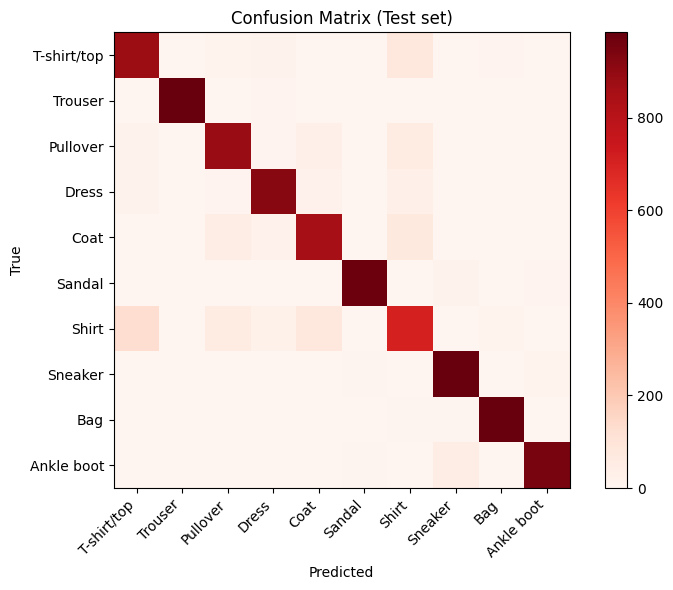

GPU: Tesla T4
Allocated MB: 19.22607421875
Reserved  MB: 46.0


In [49]:
# Load best model apparantly
model_seq.load_state_dict(torch.load("best_model_seq.pth", map_location=device))

# lets evaluate on test set
test_loss, test_acc, test_preds, test_labels = evaluate(model_seq, test_loader, criterion, device)
print(f"\nTest loss: {test_loss:.4f}  Test acc: {test_acc:.4f}")

# Classification metrics (sklearn)
from sklearn.metrics import classification_report, confusion_matrix
label_names = ["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"]

print("\nClassification report (test set):")
print(classification_report(test_labels, test_preds, target_names=label_names, digits=4))

# Confusion matrix plot
import matplotlib.pyplot as plt
import numpy as np
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8,6))
plt.imshow(cm, cmap="Reds")
plt.colorbar()
plt.xticks(np.arange(len(label_names)), label_names, rotation=45, ha='right')
plt.yticks(np.arange(len(label_names)), label_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Test set)")
plt.tight_layout()
plt.show()
print("GPU:", torch.cuda.get_device_name(0))
print("Allocated MB:", torch.cuda.memory_allocated(0) / 1024**2)
print("Reserved  MB:", torch.cuda.memory_reserved(0) / 1024**2)
